## Experiment 1 (E1): Comparison of Data Augmentation Methods
This notebook presents the results of our first experiment (E1). The goal of this experiment is to compare different data augmentation methods for microbiome data, specifically SMOTE, ADASYN, TADA, and our proposed method DBS (Distribution-Based Sampling).

### Overview of Data Augmentation Strategies

The applied data augmentation methods differ in how they modify the class distribution:
SMOTE, ADASYN, TADA-BALANCE, and DBS-BALANCE
These methods generate synthetic samples such that the minority and majority classes become equal in size. In other words, the minority class is expanded to match the size of the majority class.

TADA-BALANCE++ and DBS-BALANCE++
These approaches first balance the class distribution and then double both classes, resulting in a further increase of the total training set size.

TADA-SV-5 and DBS-5
In these variants, both classes are expanded by approximately a factor of five, regardless of the original class imbalance.

In [91]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dendropy


### Original Class Label Distribution

The first figure shows the original distribution of class labels in the dataset:
- 601 diseased samples
- 274 healthy samples

This highlights the strong class imbalance, which is a common characteristic of microbiome datasets and poses a challenge for machine learning models.

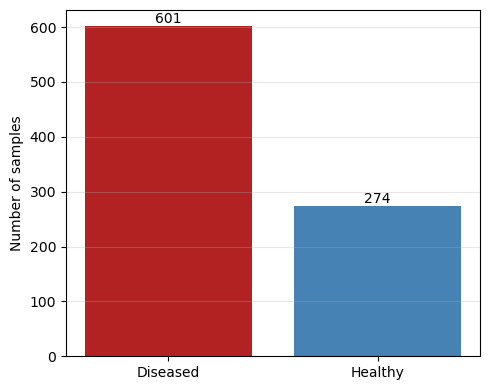

In [92]:
# Data Loading
df = pd.read_csv("../data/data.csv", index_col=0)
X = df.drop(columns=["diagnosis_binary"])
y = df["diagnosis_binary"]  

 # Pruned tree
tree = dendropy.Tree.get(
    path="../data/phylogeny_otu.tre",  
    schema="newick",
    preserve_underscores=True,
    rooting="force-rooted",
)

counts = y.value_counts().sort_index()

plt.figure(figsize=(5, 4))
bars = plt.bar(["Diseased", "Healthy"], counts.values, color=["firebrick", "steelblue"])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f"{int(height)}", ha="center", va="bottom")

plt.ylabel("Number of samples")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Class Distribution After Data Augmentation

The next figure illustrates how the class label distribution changes after applying different data augmentation techniques. It demonstrates the extent to which each method increases the number of samples, particularly for the minority class.

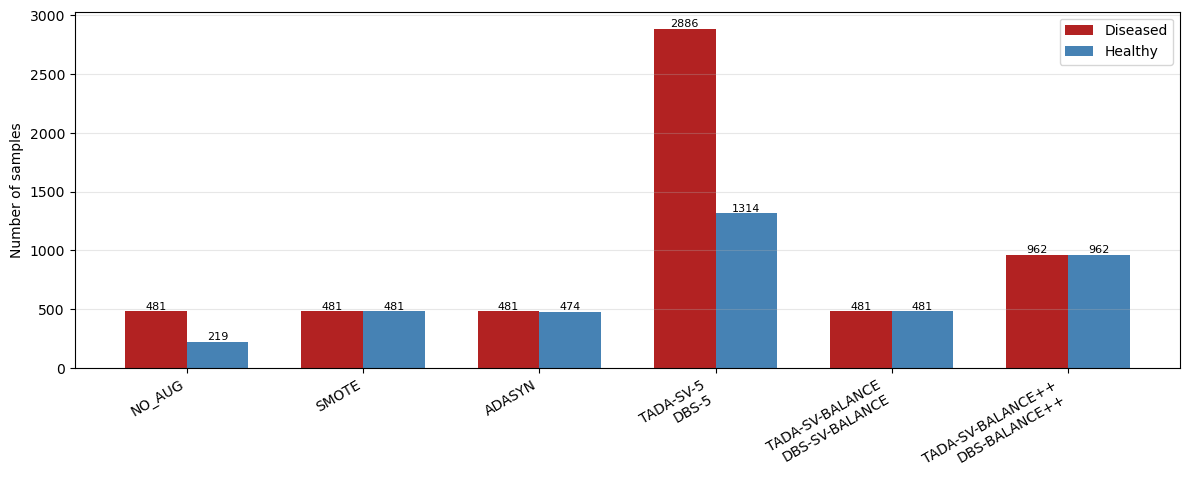

In [93]:
# Deine Daten
data = [
    {False: 481, True: 219},
    {False: 481, True: 481},
    {False: 481, True: 474},
    {False: 2886, True: 1314},
    {False: 481, True: 481},
    {False: 962, True: 962},
]

labels = [
    "NO_AUG", "SMOTE", "ADASYN",
    f"TADA-SV-5\nDBS-5", "TADA-SV-BALANCE\nDBS-SV-BALANCE", "TADA-SV-BALANCE++\nDBS-BALANCE++",
]

# Werte extrahieren
healthy = [d[True] for d in data]
diseased = [d[False] for d in data]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 5))

bars1 = plt.bar(x - width/2, diseased, width,
                label="Diseased", color="firebrick")
bars2 = plt.bar(x + width/2, healthy, width,
                label="Healthy", color="steelblue")

# Zahlen über Balken
for bars in (bars1, bars2):
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h,
                 f"{int(h)}", ha="center", va="bottom", fontsize=8)

plt.xticks(x, labels, rotation=30, ha="right")
plt.ylabel("Number of samples")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Results

The results of Experiment 1 are evaluated using two different classifiers:
- Logistic Regression
- Random Forest

Model performance is assessed using two evaluation metrics:
- AUC (Area Under the ROC Curve)
- MCC (Matthews Correlation Coefficient)

All experiments were repeated using fixed random seeds for reproducibility. The figures present boxplots of these metrics across multiple runs, allowing us to analyze both the average performance and the variability of each method.
Additionally, a table summarizes the results by reporting the mean, standard deviation, and number of runs for each metric and data augmentation method.

In [ ]:
def boxplot_metrics_by_classifier_two_cols(
    results: pd.DataFrame,
    metrics=("auc", "mcc"),
    ylims=([0.7, 0.95], [0.1, 0.7]),
    order=None,
    classifiers=("LR", "RF"),
    classifier_labels=("Logistic Regression", "Random Forest"),
    classifier_col="classifier",
    title="Performance across runs"
):
    # --- checks ---
    for col in [classifier_col, "method", *metrics]:
        if col not in results.columns:
            raise ValueError(
                f"'{col}' fehlt in results. Spalten: {results.columns.tolist()}"
            )

    if order is None:
        order = sorted(results["method"].unique())

    # ----------------------------
    # Farbzuordnung
    # ----------------------------
    def method_color(name: str):
        if name == "NO_AUG":
            return "#7F7F7F"      # grau
        elif name in ["SMOTE", "ADASYN"]:
            return "#E69F00"      # orange
        elif name.startswith("TADA"):
            return "#CC79A7"      # violett
        elif name.startswith("DBS"):
            return "#009E73"      # grün
        else:
            return "#999999"

    colors = [method_color(m) for m in order]

    # ----------------------------
    # Figure: rows=metrics, cols=classifiers
    # ----------------------------
    n_rows = len(metrics)
    n_cols = len(classifiers)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(max(12, 0.6 * len(order)), 3.2 * n_rows),
        sharex=True
    )
    axes = np.atleast_2d(axes)

    # ----------------------------
    # Plot
    # ----------------------------
    for r, (metric, ylim) in enumerate(zip(metrics, ylims)):
        for c, (clf, clf_label) in enumerate(zip(classifiers, classifier_labels)):
            ax = axes[r, c]
            df_clf = results[results[classifier_col] == clf]

            data = [
                df_clf.loc[df_clf["method"] == m, metric].dropna().values
                for m in order
            ]

            bp = ax.boxplot(
                data,
                patch_artist=True,
                widths=0.6,
                showfliers=True
            )

            for patch, color in zip(bp["boxes"], colors):
                patch.set_facecolor(color)
                patch.set_edgecolor("black")
                patch.set_alpha(0.85)

            for element in ["whiskers", "caps", "medians"]:
                for item in bp[element]:
                    item.set_color("black")

            ax.set_ylim(ylim)
            ax.grid(axis="y", alpha=0.3)

            # Column titles only on top row
            if r == 0:
                ax.set_title(clf_label)

            # Row labels only on left column
            if c == 0:
                ax.set_ylabel(metric.upper())
            else:
                ax.set_ylabel("")

            # X tick labels only on bottom row
            if r == n_rows - 1:
                ax.set_xticks(np.arange(1, len(order) + 1))
                ax.set_xticklabels(order, rotation=45, ha="right")
            else:
                ax.set_xticks(np.arange(1, len(order) + 1))
                ax.set_xticklabels([])

    #fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

order_names = [
    "NO_AUG", "SMOTE", "ADASYN",
    "TADA-SV-5", "TADA-SV-BALANCE", "TADA-SV-BALANCE++",
    "DBS-5", "DBS-BALANCE", "DBS-BALANCE++"
]


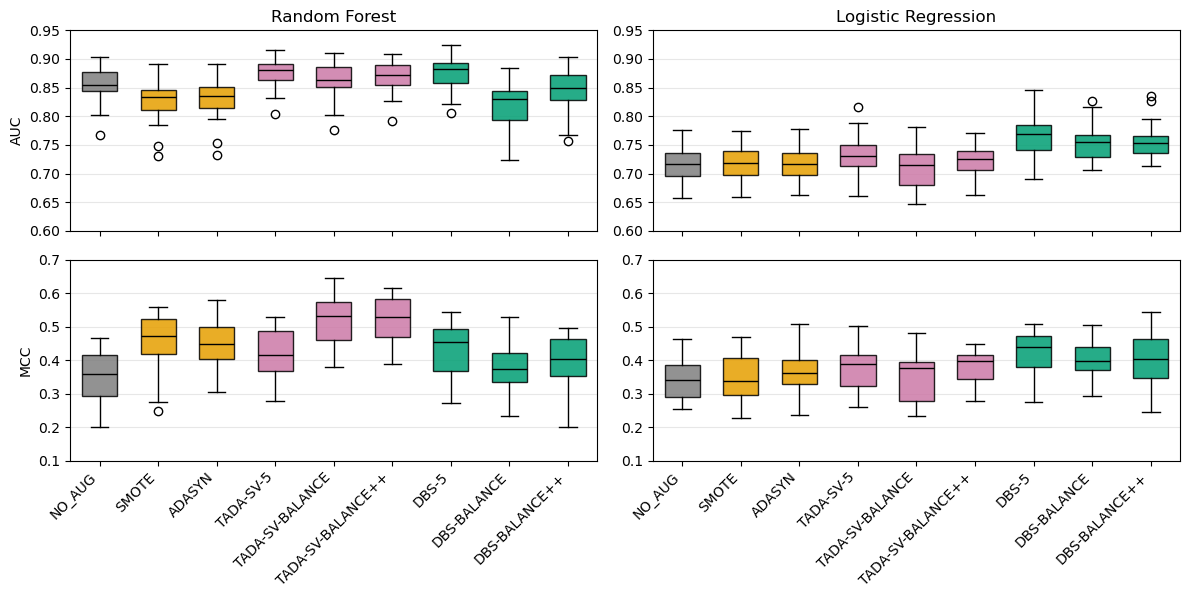

auc               mcc            
                                      mean   std count  mean   std count
model              method                                               
LogisticRegression NO_AUG             0.72  0.03    20  0.34  0.06    20
                   SMOTE              0.72  0.03    20  0.35  0.07    20
                   ADASYN             0.72  0.03    20  0.36  0.07    20
                   TADA-SV-5          0.73  0.04    20  0.38  0.07    20
                   TADA-SV-BALANCE    0.71  0.04    20  0.35  0.07    20
                   TADA-SV-BALANCE++  0.72  0.03    20  0.38  0.05    20
                   DBS-5              0.77  0.03    20  0.43  0.06    20
                   DBS-BALANCE        0.75  0.04    20  0.40  0.06    20
                   DBS-BALANCE++      0.76  0.03    20  0.40  0.08    20
RandomForest       NO_AUG             0.85  0.03    20  0.35  0.08    20
                   SMOTE              0.83  0.04    20  0.45  0.09    20
                   ADASYN             0.83  0.04    20  0.45  0.07    20
                   TADA-SV-5          0.88  0.03    20  0.42  0.08    20
                   TADA-SV-BALANCE    0.86  0.03    20  0.52  0.07    20
                   TADA-SV-BALANCE++  0.87  0.03    20  0.52  0.07    20
                   DBS-5              0.87  0.03    20  0.43  0.09    20
                   DBS-BALANCE        0.82  0.04    20  0.37  0.08    20
                   DBS-BALANCE++      0.85  0.04    20  0.40  0.08    20

In [96]:
rf_results = csv_results = pd.read_csv("../results/01_experiment/e1_rf_results.csv")
lr_results = csv_results = pd.read_csv("../results/01_experiment/e1_lr_results.csv")

results = pd.concat([rf_results, lr_results], ignore_index=True)


boxplot_metrics_by_classifier_two_cols(
    results,
    order=order_names,
    classifier_col="model",
    classifiers=("RandomForest", "LogisticRegression"),
    classifier_labels=("Random Forest", "Logistic Regression"),
    metrics=("auc", "mcc"),
    ylims=([0.6, 0.95], [0.1, 0.7]),
    #title="Moderate imbalance – AUC and MCC per classifier"
)

summary = (
    results
    .groupby(["model", "method"])[["auc", "mcc"]]
    .agg(["mean", "std", "count"])
)

summary = summary.reindex(order_names, level="method")

summary.round(2)

### Limitations

- Only two classifiers were evaluated.
- The experiment focuses on a single dataset and imbalance scenario.
- Improvements from data augmentation are moderate rather than large.